In [2]:
# Loading necessary modules.
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from os import fspath
%matplotlib inline
import seaborn as sns
import math
import pandas as pd
import MDAnalysis as mda
from MDAnalysis.analysis.align import AlignTraj
from MDAnalysis.analysis.rms import RMSD, RMSF
from MDAnalysis.analysis.pca import PCA, cosine_content
from MDAnalysis.analysis import diffusionmap
import pandas as pd

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform

/home/giacomo/micromamba/envs/QCB/lib/python3.12/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


This jupyter script has been used to concatenate and analyze 

Alignment and Concatenation of subsequent trajectories 

In [3]:
import nglview

In [4]:
data_path = "../../data_3eig/02_processed/02_npt/"
sel = 'name CA'


#concatenation 

traj_0 = data_path + "prod_0/step5_prod_0_nbc.xtc"
traj_1 = data_path + "prod_1/step5_prod_1_nbc.xtc"
traj_2 = data_path + "prod_2/step5_prod_2_nbc.xtc"
traj_3 = data_path + "prod_3/step5_prod_3_nbc.xtc"


config_file = data_path + "step5_prod_0.tpr"
concat_traj_file = data_path + "prod_cat.xtc"

# aligner and concatenation is heavy to run, if it has already been run it can be turned off by setting 'already_done' to False -GM
already_done = True 
if not already_done: 
    conc_traj = mda.Universe(config_file, [traj_0,traj_1, traj_2, traj_3])
    ref_traj = mda.Universe(config_file, traj_0)
    
    ref_traj.trajectory[0]
    aligner = AlignTraj(conc_traj,ref_traj,select=sel,filename = concat_traj_file)
    aligner.run()

In [5]:
aligned_traj = mda.Universe(config_file, concat_traj_file)

In [6]:
aligned_traj.select_atoms("resid 145:155")

<AtomGroup with 182 atoms>

In [12]:
view = nglview.show_mdanalysis(aligned_traj)
#view.add_licorice(selection = "150-160", color="yellow")
view

NGLWidget(max_frame=2603)

                                                            
                                                        RMSD and RMSF 

Text(0, 0.5, 'RMSD')

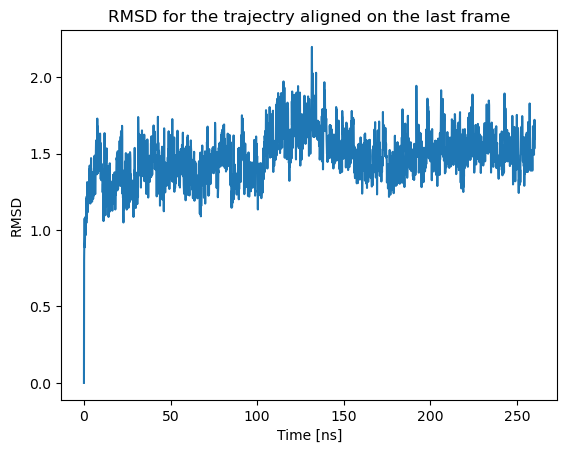

In [29]:
R = RMSD(aligned_traj, ref_traj, select=sel).run()

plt.title("RMSD for the trajectry aligned on the last frame")
plt.plot(R.results.rmsd[:,0] / 10, R.results.rmsd[:,2])
plt.xlabel('Time [ns]')
plt.ylabel('RMSD')

Text(0, 0.5, 'RMSD')

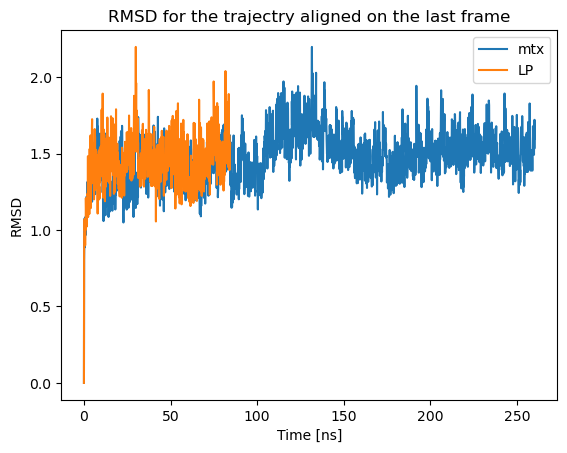

In [30]:
# comparison with lone protein
LP_path = "../../data/02_processed/02_prod/rmsd.csv"
LP_rmsd = pd.read_csv(LP_path)


plt.title("RMSD for the trajectry aligned on the last frame")
plt.plot(R.results.rmsd[:,0] / 10, R.results.rmsd[:,2], label = "mtx")
plt.plot(np.linspace(0, len(LP_rmsd["rmsd"]) / 10, num = len(LP_rmsd["rmsd"])), LP_rmsd["rmsd"], label = "LP")
plt.legend()
plt.xlabel('Time [ns]')
plt.ylabel('RMSD')

Text(0, 0.5, 'RMSF')

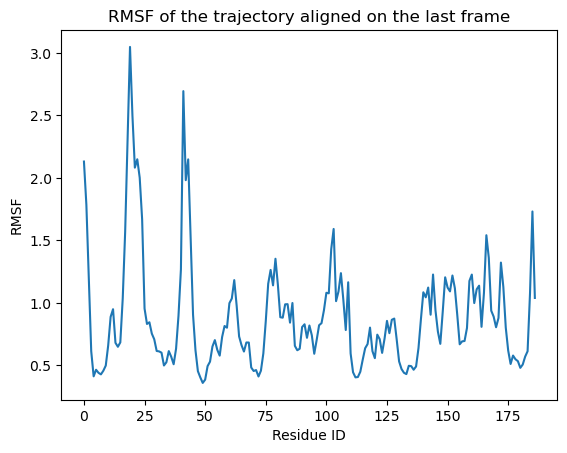

In [11]:
RF = RMSF(aligned_traj.select_atoms(sel)).run()

plt.title('RMSF of the trajectory aligned on the last frame')
plt.plot(RF.results.rmsf)
plt.xlabel('Residue ID')
plt.ylabel('RMSF')

Text(0, 0.5, 'RMSF')

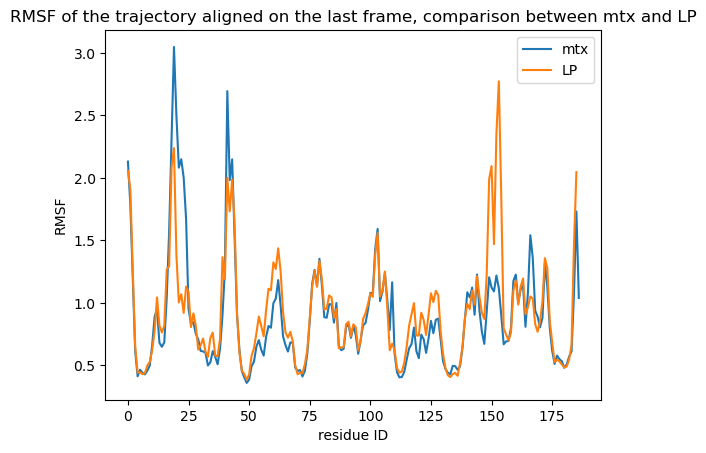

In [32]:
# comparison with lone protein
LP_path = "../../data/02_processed/02_prod/rmsf.csv"
LP_rmsf = pd.read_csv(LP_path)

plt.title('RMSF of the trajectory aligned on the last frame, comparison between mtx and LP')
plt.plot(RF.results.rmsf, label = "mtx")
plt.plot(LP_rmsf["rmsf"], label = "LP")
plt.legend()
plt.xlabel('residue ID')
plt.ylabel('RMSF')

Principal Component Analysis 

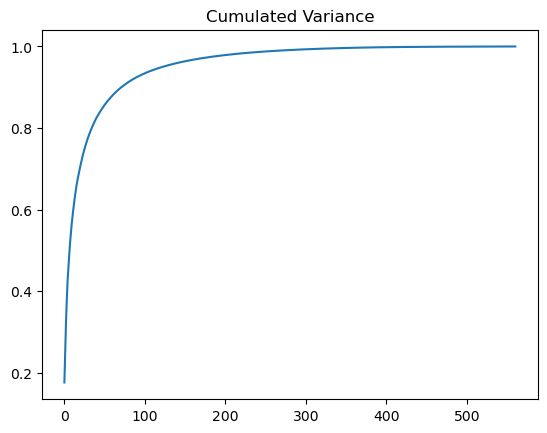

In [33]:
pca = PCA(aligned_traj, select=sel)
pca.run()


plt.title('Cumulated Variance')
plt.plot(pca.results.cumulated_variance)

In [34]:
pca_space = pca.transform(conc_traj.select_atoms(sel),2)
pca_data = pd.DataFrame(pca_space, columns=['first_comp','second_comp'])
pca_data["group"] = pca_data.index // 40

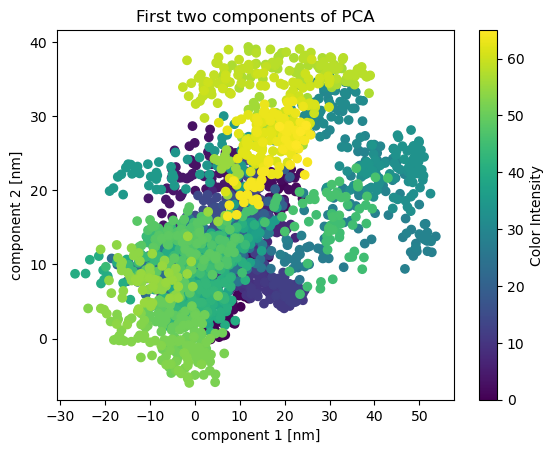

In [35]:
plt.title("First two components of PCA")
scatter = plt.scatter(pca_data['first_comp'], pca_data['second_comp'], c=pca_data['group'])
plt.xlabel("component 1 [nm]")
plt.ylabel("component 2 [nm]")
plt.colorbar(scatter, label = 'Color Intensity')